In [1]:
import json
import os
import collections
import pandas as pd
from altair import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [205]:
def pd2alt(df):
    return Data(values = df.to_dict('records'))

In [321]:
keys = ['ours', 'ce', 'gl']

In [336]:
files = os.listdir('user_data/')
covered = set()
count = 0
statsdict = collections.defaultdict(list)
r1, r2, r3 = [], [], []
for name in files:
    if '.json' not in name: continue
    # print(name)
    count += 1
    with open('user_data/' + name, 'r') as f:
        d = json.load(f)
        tmpDict = collections.defaultdict(int)
        numItem = 0
        for item in d:
            if 'rank_result' in item:
                covered.add(item['rank_result'][0].split('/')[1].split('_')[0])
                t = [i.split('/')[0] for i in item['rank_result']]
                tmpDict[t[0]] += 1; numItem += 1
                r1.append(t[0])
                r2.append(t[1])
                r3.append(t[2])
        for key in keys:
            statsdict[key].append(tmpDict[key]/numItem if key in tmpDict else 0)
print('number of subjects:', count)
print('number of covered images:', len(covered))
print('coverage rate:', len(covered) / 3000)

number of subjects: 32
number of covered images: 2018
coverage rate: 0.6726666666666666


In [261]:
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

In [349]:
turkey_data = []
for key in statsdict:
    for val in statsdict[key]:
        turkey_data.append((key, val))
turkey_df = pd.DataFrame(turkey_data)

In [329]:
scipy.stats.f_oneway(statsdict['ours'], statsdict['ce'], statsdict['gl'])

F_onewayResult(statistic=300.08025417535657, pvalue=2.7269983212374945e-41)

In [402]:
summary = pairwise_tukeyhsd(turkey_df[1], turkey_df[0]).summary()

In [431]:
ts = summary.as_csv().split('\n')[1:]
ts = [s.split(',') for s in ts]

In [437]:
tdf = pd.DataFrame(ts, columns=ts[0])

In [438]:
tdf.drop(tdf.index[0], inplace=True)

In [443]:
tdf.to_csv('Tukey.csv', index=False, sep='\t')

In [246]:
r1 = collections.Counter(r1)
r2 = collections.Counter(r2)
r3 = collections.Counter(r3)
total = sum(r1[k] for k in r1)

In [247]:
r1

Counter({'ce': 315, 'gl': 265, 'ours': 2620})

In [248]:
plot_data = []
for k in dict(r1):
    plot_data.append({
        'rank': '1st',
        'method': k.upper(),
        'count': dict(r1)[k]
    })

for k in dict(r2):
    plot_data.append({
        'rank': '2nd',
        'method': k.upper(),
        'count': dict(r2)[k]
    })

for k in dict(r3):
    plot_data.append({
        'rank': '3rd',
        'method': k.upper(),
        'count': dict(r3)[k]
    })

In [372]:
df = pd.DataFrame(plot_data)
df['percentage'] = df['count'].apply(lambda x: x / total)
df['formatted_percentage'] = pd.Series(["{0:.01%}".format(val) for val in df['percentage']], index = df.index)
df['method_order'] = [0 if m=='OURS' else 1 if m=='CE' else 2 for m in df['method']]

In [252]:
with open("rank_plot.vg.json", 'r') as f:
    vega_scheme = json.load(f)
    vega_scheme['data'] = json.loads(pd2alt(df).to_json())
with open("rank_plot.vg.json", 'w') as f:
    json.dump(vega_scheme, f)

In [400]:
df.to_csv('stacked_bar.csv', index=False)

In [380]:
df['method'][lambda k: k == 'GL']

1    GL
4    GL
6    GL
Name: method, dtype: object

In [397]:
df['rank_order'] = [2 if st=='1st' else 1 if st=='2nd' else 0 for st in df['rank']]

In [398]:
df

,count,method,rank,percentage,formatted_percentage,method_order,rank_order
0,2620,OURS,1st,0.818750,81.9%,0,2
1,265,GL,1st,0.082812,8.3%,2,2
2,315,CE,1st,0.098437,9.8%,1,2
3,1628,CE,2nd,0.508750,50.9%,1,1
4,1170,GL,2nd,0.365625,36.6%,2,1
5,402,OURS,2nd,0.125625,12.6%,0,1
6,1765,GL,3rd,0.551562,55.2%,2,0
7,1257,CE,3rd,0.392813,39.3%,1,0
8,178,OURS,3rd,0.055625,5.6%,0,0


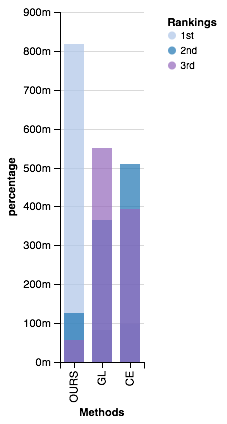

In [399]:
Chart(df).mark_bar().encode(
    color=Color('rank:N',
                legend=Legend(title='Rankings'),
                scale=Scale(
                    domain=['1st', '2nd', '3rd'],
                    range=['#aec7e8', '#1f77b4', '#9467bd'],
                ),
               ),
    x=X('method:N', sort='descending', axis=Axis(title='Methods')),
    y=Y('percentage:Q')
)